In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from keras import backend as K 
from keras.preprocessing.image import ImageDataGenerator 
from keras.models import Sequential
from keras.models import Model 
from keras.layers import Conv2D, MaxPooling2D 
from keras.layers import Activation, Dropout, Flatten, Dense
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.applications import InceptionResNetV2 
! pip install split-folders
import tensorflow as tf
import split_folders
from keras import optimizers

Using TensorFlow backend.


In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import densenet
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import regularizers
from keras import backend as K
from keras import optimizers

In [0]:
!unzip /content/drive/My\ Drive/NN-ProjectC/Version-2/Training/Augmented_Data.zip

In [0]:
training_data_folder = "/content/Augmented_Data"
split_folders.ratio(training_data_folder, output = "train_val", seed=0, ratio = (.7,.3))

Copying files: 12824 files [00:03, 3921.65 files/s]


In [0]:
train_data_dir = "train_val/train"
val_data_dir = "train_val/val"
num_train = 0
num_val = 0

for i in os.listdir(train_data_dir):
  if i.startswith("."):
    os.rmdir(os.path.join(train_data_dir, i))
  else:
    num_train += len(os.listdir(os.path.join(train_data_dir, i)))
  
for i in os.listdir(val_data_dir):
  if i.startswith("."):
    os.rmdir(os.path.join(val_data_dir, i))
  else:
    num_val += len(os.listdir(os.path.join(val_data_dir, i)))

img_width, img_height = 224, 224
# Check if the images are RGB and change the channels likewise
if K.image_data_format() == 'channels_first':
  input_shape= (3, img_width, img_height)
else:
  input_shape = (img_width, img_height, 3)

In [0]:
from keras.applications.densenet import DenseNet121

base_model = DenseNet121(input_shape=(224, 224, 3),
                                  weights='imagenet',
                                  include_top = False,
                                  pooling='avg')

for layer in base_model.layers:
  layer.trainable = True

x = base_model.output
x = Dense(1000)(x)

x = Activation('relu')(x)
x = Dense(500)(x)

x = Activation('relu')(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss = "categorical_crossentropy", optimizer = optimizers.Adam(), metrics = ['accuracy'])

model.summary()














29089792/29084464 [==============================] - 1s 0us/step


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

def get_callbacks():

   path_checkpoint ='checkpoint_keras'  
   log_dir='logs'
   
   callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                         monitor='val_loss',
                                         verbose=1,
                                         save_weights_only=False,
                                         save_best_only=True,
                                         mode='max',
                                         period=1)
   
   callback_early_stopping = EarlyStopping(monitor='val_loss',
                                           patience=5,
                                           verbose=1)
   
   callback_tensorboard = TensorBoard(log_dir=log_dir,
                                      histogram_freq=0,
                                      write_graph=False)
   
   callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                          factor=0.1,
                                          min_lr=1e-4,
                                          patience=3,
                                          verbose=1)

   callbacks = [callback_checkpoint, callback_tensorboard, callback_reduce_lr]

   return callbacks

In [0]:
batch_size = 32

epochs = 100

train_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(train_data_dir, 
                                                    target_size =(img_width, img_height), 
                                                    batch_size = batch_size, class_mode = 'categorical')

validation_generator = train_datagen.flow_from_directory( val_data_dir, 
                                                         target_size =(img_width, img_height), 
                                                         batch_size = batch_size, class_mode ='categorical') 

model.fit_generator(train_generator, 
                    steps_per_epoch = num_train // batch_size, 
                    epochs = epochs, 
                    validation_data = validation_generator, 
                    validation_steps = num_val// batch_size, 
                    callbacks = get_callbacks())

model.save_weights("data_aug.h5")

Found 8974 images belonging to 5 classes.
Found 3850 images belonging to 5 classes.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Epoch 1/100
280/280 [==============================] - 319s 1s/step - loss: 0.9116 - acc: 0.6275 - val_loss: 1.2639 - val_acc: 0.5677

Epoch 00001: val_loss improved from -inf to 1.26386, saving model to checkpoint_keras

Epoch 2/100
280/280 [==============================] - 284s 1s/step - loss: 0.6610 - acc: 0.7383 - val_loss: 0.7170 - val_acc: 0.6797

Epoch 00002: val_loss did not improve from 1.26386
Epoch 3/100
280/280 [==============================] - 283s 1s/step - loss: 0.5194 - acc: 0.7886 - val_loss: 0.8007 - val_acc: 0.7142

Epoch 00003: val_loss did not improve from 1.26386
Epoch 4/100
280/280 [==============================] - 283s 1s/step - loss: 0.4121 - acc: 0.8423 - val_loss: 0.5762 - val_acc: 0.8004

Epoch 00004: val_loss did not improve from 1.26386
Epoch 5/100
280/280 [=================

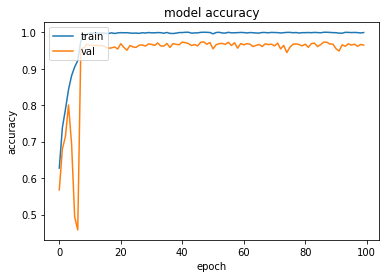

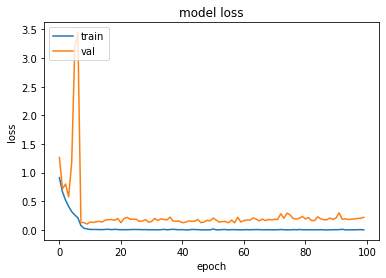

In [0]:
history = model.history

import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("Accuracy_curves.png")
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("Loss_curves.png")

In [0]:
import numpy
import sklearn.metrics as metrics
img_width, img_height = 224, 224
batch_size = 8
epochs = 100
test_set_dir = "/content/drive/My Drive/NN-ProjectC/Testing"

num_test = len(os.listdir(test_set_dir))

print ("Number of images in test set: ", num_test)

#model = get_model(0.0001)

#model.load_weights("/content/model_new1.h5")
  
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(test_set_dir, target_size =(img_width, img_height), 
                                                  batch_size = batch_size, class_mode =None, shuffle = False) 

test_steps_per_epoch = numpy.math.ceil(test_generator.samples / test_generator.batch_size)

predictions = model.predict_generator(test_generator, steps = test_steps_per_epoch)

print("PREDICTIONS: --->")
print(predictions)

predicted_classes = numpy.argmax(predictions, axis=1)

print("PREDICTED CLASSES: --->")
print (predicted_classes)

Number of images in test set:  1
Found 129 images belonging to 1 classes.
PREDICTIONS: --->
[[1.73102971e-02 9.82689738e-01 5.35851875e-12 1.47401934e-11
  1.24530716e-13]
 [7.21543193e-01 2.78456777e-01 5.83955384e-10 5.38700329e-09
  2.40853448e-11]
 [1.79085594e-10 2.41920226e-08 1.28883926e-08 1.00000000e+00
  2.18465850e-08]
 [2.93658572e-15 1.78514166e-16 1.28543264e-14 2.77485876e-14
  1.00000000e+00]
 [2.73425462e-06 9.99990106e-01 1.25241445e-06 5.86489841e-06
  3.47989761e-08]
 [8.03606110e-14 1.06877710e-11 9.71635879e-12 1.00000000e+00
  2.57577848e-11]
 [9.99999762e-01 1.84351535e-07 1.16402513e-11 1.69903785e-10
  6.19901359e-15]
 [2.46388709e-06 1.50779954e-06 2.02871456e-06 9.99668479e-01
  3.25543690e-04]
 [1.28898313e-02 6.82720959e-01 2.95522332e-01 8.70900042e-03
  1.57778355e-04]
 [3.03220956e-14 7.13221986e-15 4.17255613e-13 5.75007706e-13
  1.00000000e+00]
 [4.86598922e-18 3.49012440e-18 1.45758012e-15 1.83923231e-15
  1.00000000e+00]
 [7.02638865e-01 2.97361135e

In [0]:
test_generator.filenames

['Project_C2_Testing/000561.jpg',
 'Project_C2_Testing/000747.jpg',
 'Project_C2_Testing/000810.jpg',
 'Project_C2_Testing/000934.jpg',
 'Project_C2_Testing/001133.jpg',
 'Project_C2_Testing/001140.jpg',
 'Project_C2_Testing/001273.jpg',
 'Project_C2_Testing/001506.jpg',
 'Project_C2_Testing/001621.jpg',
 'Project_C2_Testing/001659.jpg',
 'Project_C2_Testing/002185.jpg',
 'Project_C2_Testing/002282.jpg',
 'Project_C2_Testing/002433.jpg',
 'Project_C2_Testing/002532.jpg',
 'Project_C2_Testing/002593.jpg',
 'Project_C2_Testing/002762.jpg',
 'Project_C2_Testing/002764.jpg',
 'Project_C2_Testing/002864.jpg',
 'Project_C2_Testing/003145.jpg',
 'Project_C2_Testing/003386.jpg',
 'Project_C2_Testing/003448.jpg',
 'Project_C2_Testing/003550.jpg',
 'Project_C2_Testing/003825.jpg',
 'Project_C2_Testing/003880.jpg',
 'Project_C2_Testing/004191.jpg',
 'Project_C2_Testing/004539.jpg',
 'Project_C2_Testing/004597.jpg',
 'Project_C2_Testing/004898.jpg',
 'Project_C2_Testing/004973.jpg',
 'Project_C2_T

In [0]:
from tensorflow.keras.utils import to_categorical
y_pred = to_categorical(predicted_classes, dtype = 'int32')

In [0]:
import csv

with open('labels.csv', 'wt') as output:
    writer = csv.writer(output)
    writer.writerows(y_pred)    
output.close()

In [0]:
import pickle
f = open('history_final.pckl', 'wb')
pickle.dump(history.history, f)
f.close()